In [1]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import fAux
import matplotlib.pyplot as plt
import seaborn as sns
import sys
# import talib as ta
import ta
# from ta.trend import EMAIndicator, SMAIndicator

from category_encoders import TargetEncoder

np.random.seed(1) #to fix the results
rs = 2

In [3]:
#df = pd.read_csv('EURUSD_H3_200001030000_202107201800.csv', sep='\t')
#df = pd.read_csv('GBPUSD_H3_200001030000_202107201800.csv', sep='\t')
#df = pd.read_csv('NZDUSD_H3_200001030000_202107201800.csv', sep='\t')
df = pd.read_csv('USDCAD_H3_200001030000_202107201800.csv', sep='\t')
#df = pd.read_csv('USDCHF_H3_200001030000_202107201800.csv', sep='\t')

df['<DATETIME>'] = pd.to_datetime(df['<DATE>'] + ' ' + df['<TIME>'])
df = df.set_index('<DATETIME>')
df.drop(['<TIME>'], axis=1, inplace=True)
df.drop(['<DATE>'], axis=1, inplace=True)

#save the open for white reality check
openp = df['<OPEN>'].copy()
close = df['<CLOSE>'].copy()

window_features = []
#buld the best window features after the exploratory data analysis:
for n in list(range(1,15)):
    name = 'ret' + str(n)
    window_features.append(name)
    df[name] = df["<OPEN>"].pct_change(periods=n) #for trading with open
    #df[name] = df["<CLOSE>"].pct_change(periods=n) #for trading with close

#build date-time features
df["hour"] = df.index.hour.values
df["day"] = df.index.dayofweek.values

#build target assuming we know today's open
df['retFut1'] = df['<OPEN>'].pct_change(1).shift(-1).fillna(0) #if you enter the trade immediately after the open
#df['retFut1'] = df['<CLOSE>'].pct_change(1).shift(-1) #if you wait until the close to enter the trade
#df = np.log(df+1)

"""
"""
#transform the target
#you have the option of a 3 label target or a 2 label target

#2 label target
#df['retFut1_categ']=0
#df.loc[df['retFut1']>df['retFut1'][:10000].quantile(q=0.51),'retFut1_categ']=1

#3 label target gets better results
df['retFut1_categ']=0
df.loc[df['retFut1']>df['retFut1'][:10000].quantile(q=0.66),'retFut1_categ']=1
df.loc[df['retFut1']<df['retFut1'][:10000].quantile(q=0.34),'retFut1_categ']=-1



#always check to see that the labels occur in equal numbers
dfgroups = df.groupby("retFut1_categ").count() #if they do not, use "balanced" parameter in the estimator(see below)

#Since we are trading right after the open, 
#we only know yesterday's  high low close volume spread etc.
df['<HIGH>'] = df['<HIGH>'].shift(1)
df['<LOW>'] = df['<LOW>'].shift(1)
df['<CLOSE>'] = df['<CLOSE>'].shift(1)
df['<VOL>'] = df['<VOL>'].shift(1)
df['<SPREAD>'] = df['<SPREAD>'].shift(1)

#Build some Ta-lib features, with n=10, to be optiized in the pipeline
n=10
# df['RSI']=ta.RSI(np.array(df['<CLOSE>']), timeperiod=n)
df['RSI']= ta.momentum.RSIIndicator(close=df['<CLOSE>'], window=n).rsi()

df['SMA'] = df['<CLOSE>'].rolling(window=n).mean()
df['Corr']= df['<CLOSE>'].rolling(window=n).corr(df['SMA'])

# df['SAR']=ta.SAR(np.array(df['<HIGH>']),np.array(df['<LOW>']), 0.2,0.2)
df['SAR']=ta.trend.PSARIndicator(high=df['<HIGH>'], 
                                    low=df['<LOW>'],
                                    close=df['<CLOSE>'],
                                    step=0.2, 
                                    max_step=0.2).psar()

# df['ADX']=ta.ADX(np.array(df['<HIGH>']),np.array(df['<LOW>']), np.array(df['<OPEN>']), timeperiod =n)
df['ADX']=ta.trend.ADXIndicator(high=df['<HIGH>'], 
                                low=df['<LOW>'], 
                                close=df['<CLOSE>'], 
                                window=n).adx()


df['OO']= df['<OPEN>']-df['<OPEN>'].shift(1)
df['OC']= df['<OPEN>']-df['<CLOSE>']
df.fillna(0, inplace=True)

#select the features (by dropping)
cols_to_drop = ["<TICKVOL>","<VOL>","<SPREAD>"]  #optional
df_filtered = df.drop(cols_to_drop, axis=1)

#distribute the df data into X inputs and y target
X = df_filtered.drop(['retFut1', 'retFut1_categ'], axis=1) 
y = df_filtered[['retFut1_categ']]

#select the samples
x_train = X.iloc[0:10000]
x_test = X.iloc[10000:12000]

y_train = y.iloc[0:10000]
y_test = y.iloc[10000:12000]

df_train = df_filtered.iloc[0:10000]
df_test = df_filtered.iloc[10000:12000]# use target encoding to encode two categorical features


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
import phik
from phik.report import plot_correlation_matrix
from scipy.special import ndtr
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import matthews_corrcoef
from sklearn.ensemble import RandomForestClassifier
import detrendPrice 
import WhiteRealityCheckFor1 
from sklearn.decomposition import PCA
import pywt
from sklearn.preprocessing import StandardScaler



def phi_k(y_true, y_pred):
    dfc = pd.DataFrame({'y_true': y_true, 'y_pred': y_pred})
    try:
        phi_k_corr = dfc.phik_matrix(interval_cols=[]).iloc[1,0]
        phi_k_sig  = dfc.significance_matrix(interval_cols=[]).iloc[1,0]
        phi_k_p_val = 1 - ndtr(phi_k_sig) 
    except:
        phi_k_corr = 0
        phi_k_p_val = 0
    #print(phi_k_corr)
    print(phi_k_p_val)
    return phi_k_corr

#ph_k is supposed to be better than phi, provided here for comparison
def phi(y_true, y_pred):
    mcc = matthews_corrcoef(y_true,y_pred) #a.k.a. phi
    print (mcc)
    return mcc

#for optimizing the timeperiod of RSI and ADX
#x is a dataframe because this happens first in the pipeline
def RSI_ADX_optimizer(x, timeperiod=10):
    # x[4] =ta.RSI(x[3], timeperiod=timeperiod) 
    # x[5] = ta.ADX(x[1],x[2], x[0], timeperiod=timeperiod)
    # x[0]x[1]x[2]x[3]x[4]x[5] are '<OPEN>','<HIGH>','<LOW>','<CLOSE>','RSI', 'ADX' 

    # modified; use df instead of numpy arrays
    x = x.copy()  # don't modify original

    x['RSI'] = ta.momentum.RSIIndicator(close=x['<CLOSE>'], window=timeperiod).rsi()
    x['ADX'] = ta.trend.ADXIndicator(
        high=x['<HIGH>'],
        low=x['<LOW>'],
        close=x['<CLOSE>'],
        window=timeperiod
    ).adx()

    x['RSI'] = x['RSI'].fillna(0)
    x['ADX'] = x['ADX'].fillna(0)
    return x

def target_encoder (X, y):
    # use target encoding to encode the categorical features
    x_train_enc = pd.DataFrame(X, columns=x_train.columns)
    y_train_enc = X.join(y).retFut1_categ #do a join of x with y. Why?
    enc = TargetEncoder(cols=['hour', 'day'])
    # transform the datasets
    x_train_enc = enc.fit_transform(x_train_enc, y_train_enc)
    x_train_enc =x_train_enc.fillna(0)
    return x_train_enc


def wavelet_smoother(x_train, scale=None):
        wavelet = "db6"
        x_train = pd.DataFrame(x_train)
        df_wavelets = x_train.copy()
        
        for i in x_train.columns:
            signal = x_train[i]
            coefficients = pywt.wavedec(signal, wavelet, mode='per')
            coefficients[1:] = [pywt.threshold(i, value=scale*signal.max(), mode='soft') for i in coefficients[1:]]
            reconstructed_signal = pywt.waverec(coefficients, wavelet, mode='per')
            df_wavelets[i] = reconstructed_signal
        
        df_wavelets = df_wavelets.fillna(0)
        return df_wavelets

#myscorer= "accuracy"  #same as None; 
#myscorer = make_scorer(phi_k, greater_is_better=True)
myscorer="f1_macro"
#my_scorer="f1_weighted" 
#myscorer = make_scorer(phi, greater_is_better=True) 

In [20]:
"""
INSTRUCTIONS
make sure that TimeSeriesSplit is being activated during RandomizedSearchCV and GridSearchCV
to presere the chronological order of the input series during the construction of the folds.
TimeSeriesSplit is documented here:
https://archive.is/8FZtM
Change the value of split from split=5 to the split created by TimeSeriesSplit with
n_splits set to 5 and max_train_size set to 2000.

"""

#when using smoother, use TimesSeriesSplit
#split = 5 
split = TimeSeriesSplit(n_splits=5, max_train_size=2000) #fixed size window
#split = TimeSeriesSplit(n_splits=5)

"""
INSTRUCTIONS
wrap the custom RSI_ADX_optimizer and the custom wavelet_smoother in a FunctionTransformer object
so as to provide these functions with a fit_transform method.
Do the same for the target_encoder method.
As regards targetencoder, remember to add kw_args={'y': y_train} as second argument of the FunctionTransformer function.
"""

# rsiadx = #####
# waveletsmoother = #####
# targetencoder = #####

rsiadx = FunctionTransformer(RSI_ADX_optimizer, validate=False)
waveletsmoother = FunctionTransformer(wavelet_smoother, validate=False)
targetencoder = FunctionTransformer(target_encoder, validate=False)

In [29]:
print(x_train.dtypes)
categorical_features_ix = x_train.select_dtypes(include=['int64']).columns
numeric_features_ix = x_train.select_dtypes(include=['float64']).columns
all_features_ix = x_train.columns

talib_features_no = []
for c in list(['<OPEN>','<HIGH>','<LOW>','<CLOSE>','RSI', 'ADX']):
    talib_features_no.append(x_train.columns.get_loc(c))

window_features_no = []
for c in window_features:
    window_features_no.append(x_train.columns.get_loc(c))
    
categorical_features_no = []
for i in categorical_features_ix:
    categorical_features_no.append(x_train.columns.get_loc(i))
    
numeric_features_no = []
for i in numeric_features_ix:
    numeric_features_no.append(x_train.columns.get_loc(i))

all_features_no = []
for i in all_features_ix:
    all_features_no.append(x_train.columns.get_loc(i))


<OPEN>     float64
<HIGH>     float64
<LOW>      float64
<CLOSE>    float64
ret1       float64
ret2       float64
ret3       float64
ret4       float64
ret5       float64
ret6       float64
ret7       float64
ret8       float64
ret9       float64
ret10      float64
ret11      float64
ret12      float64
ret13      float64
ret14      float64
hour         int32
day          int32
RSI        float64
SMA        float64
Corr       float64
SAR        float64
ADX        float64
OO         float64
OC         float64
dtype: object


In [30]:
"""
INSTRUCTIONS
#Define your transformers here
#Note: transformer 3-element tuples can be: ('name', function or pipeline, column_number_list or column_index)
talib should apply to talib_features_no, use the custome talib optimizer from above
imputer should apply to numeric_features_no, use the same imputer we have used so far
smoother should apply to window_features_no, use the custom wavelet smoother from above
extractor should apply to numeric_features_no, use PCA
ignore for now the extractor that is commented out (you can uncomment it later to experiment)
encoder should apply to all_features_no, use target_encoder from above
make all the transformers' remainder parameter 'passthrough'
"""

# encoder = #####
# talib = #####
# imputer = #####
# smoother =  #####
# extractor = #####

encoder = ColumnTransformer(transformers=[('targetencoder', targetencoder, categorical_features_no)], remainder='passthrough') 
talib = ColumnTransformer(transformers=[('rsiadx', rsiadx, talib_features_no)], remainder='passthrough')
imputer = ColumnTransformer(transformers=[('imputer', SimpleImputer(strategy='mean'), numeric_features_no)], remainder='passthrough') 
smoother =  ColumnTransformer(transformers=[('waveletsmoother', waveletsmoother, window_features_no)], remainder='passthrough') 
extractor = ColumnTransformer(transformers=[('pca', PCA(), numeric_features_no)], remainder='passthrough')




#extractor = ColumnTransformer(transformers=[('pca', PCA(), all_features_no)], remainder='passthrough') #include target_encoded variables
#encoder = ColumnTransformer(transformers=[('onehot',  OneHotEncoder(handle_unknown='ignore'), categorical_features_no)], remainder='passthrough') #use one hot encoding instead of target encoding
#once you encode the categorical features, you can transform them with PCA, again this is optional, you can try it both ways and see which way produces the better result.

#rfc = RandomForestClassifier(class_weight='balanced') #to balance the label categories, if they do not occur in equal numbers
rfc = RandomForestClassifier() 


In [31]:
"""
INSTRUCTIONS
#Define your pipeline with the encoder as the first step in the pipeline because
the X input of the encoder needs to be a dataframe not an array, and
if you order the encoder as the second step in the pipeline, the X input will be an array
"""

# pipe = #####
pipe = Pipeline(steps=[
                      ('talib', talib),
                      ('encoder', encoder),
                      ('imputer', imputer),
                      ('smoother', smoother),
                      ('extractor', extractor),
                      ('rfc', rfc)])    


In [32]:
"""
INSTRUCTIONS
#Define your parameter choices
Just use 2 values for each or fitting will take a long time
"""

# n_estimators_rs = #####
# timeperiod_rs = #####
# n_components_rs = ####
# scales_rs = ####

n_estimators_rs = [100, 200]
timeperiod_rs = [5, 10]
n_components_rs = [2, 3]
scales_rs = [0.1, 0.2]


In [33]:
#Define your param_grid dictionary
param_grid = {
    'talib__rsiadx__kw_args': [{'timeperiod': tp} for tp in timeperiod_rs],
    'smoother__waveletsmoother__kw_args': [{'scale': s} for s in scales_rs],
    'extractor__pca__n_components':  n_components_rs, 
    'rfc__n_estimators': n_estimators_rs
}


grid_search = RandomizedSearchCV(pipe, param_grid, cv=split, scoring=myscorer, random_state=2)
#grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring=myscorer, return_train_score=True)

grid_search.fit(x_train, y_train.values.ravel())

best_parameters = grid_search.best_params_
best_model = grid_search.best_estimator_


print("Best parameters : {}".format(best_parameters))
#print('Best estimator {}'.format(best_model))
print("Best cross-validation score : {:.2f}".format(grid_search.best_score_*100))
results = pd.DataFrame(grid_search.cv_results_)

#print(results.T)
results.to_csv("results_rfc.csv")

Best parameters : {'talib__rsiadx__kw_args': {'timeperiod': 5}, 'smoother__waveletsmoother__kw_args': {'scale': 0.2}, 'rfc__n_estimators': 200, 'extractor__pca__n_components': 3}
Best cross-validation score : 42.89


In [16]:
for i in grid_search.estimator.get_params().keys():
    if 'rfc__n_estimators' in i:
        print(i)
        break


rfc__n_estimators


In-sample: CAGR=0.288031 Sharpe ratio=12.7216 maxDD=-0.00108191 maxDDD=7 Calmar ratio=266.223

Out-of-sample: CAGR=0.0676528 Sharpe ratio=2.04793 maxDD=-0.0296473 maxDDD=121 Calmar ratio=2.28192  phi_k_corr=0.291668 phi_k_p_val=2.44286e-08  accuracy_score=0.3945

Ljung-Box test p-value 0.10345921667317427
average return 0.003316
[-0.00287939  0.00285309]
Reject Ho = The population distribution of rule returns has an expected value of zero or less (because p_value is small enough)
p_value:
0.010399999999999965


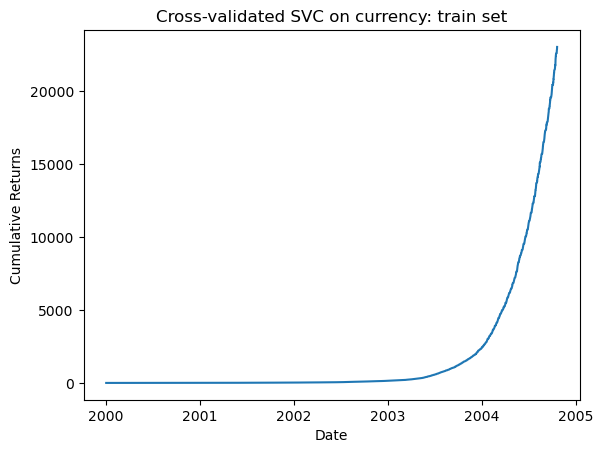

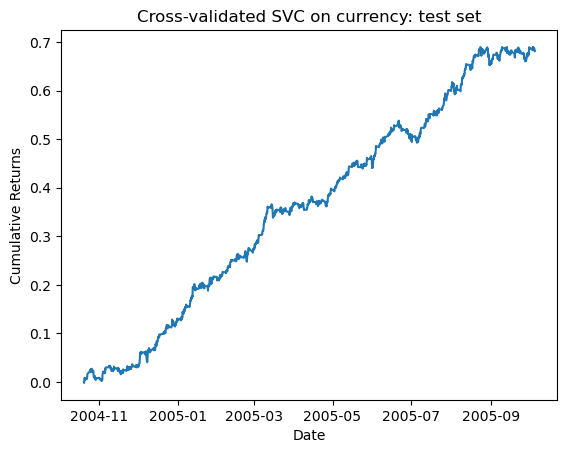

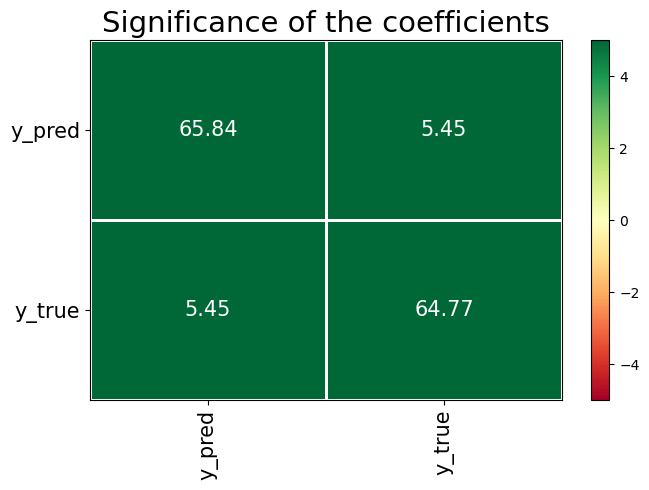

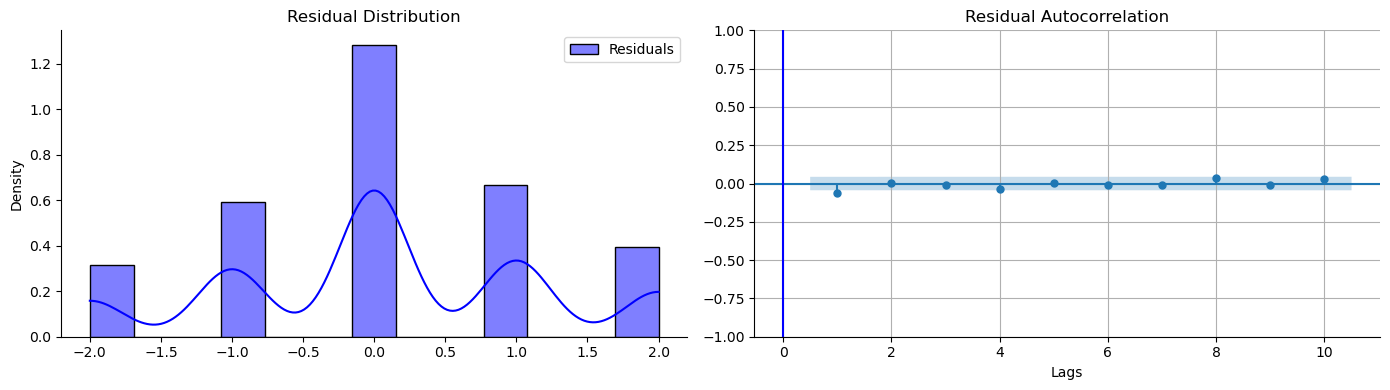

In [35]:
# Train set
# Make "predictions" on training set (in-sample)
#positions = np.where(best_model.predict(x_train)> 0,1,-1 )
positions = np.where(grid_search.predict(x_train)> 0,1,-1 ) #POSITIONS

#dailyRet = pd.Series(positions).shift(1).fillna(0).values * x_train.ret1 #for trading at the close
dailyRet = pd.Series(positions).fillna(0).values * df_train.retFut1 #for trading right after the open

dailyRet = dailyRet.fillna(0)

cumret = np.cumprod(dailyRet + 1) - 1


plt.figure(1)
plt.plot(cumret.index, cumret)
plt.title('Cross-validated SVC on currency: train set')
plt.ylabel('Cumulative Returns')
plt.xlabel('Date')
#plt.show()
plt.savefig(r'Results\%s.png' %("TrainCumulative"))


cagr = (1 + cumret[-1]) ** (252 / len(cumret)) - 1
maxDD, maxDDD = fAux.calculateMaxDD(cumret)
ratio = (252.0 ** (1.0/2.0)) * np.mean(dailyRet) / np.std(dailyRet)
print (('In-sample: CAGR={:0.6} Sharpe ratio={:0.6} maxDD={:0.6} maxDDD={:d} Calmar ratio={:0.6}\n'\
).format(cagr, ratio, maxDD, maxDDD.astype(int), -cagr/maxDD))

# Test set
# Make "predictions" on test set (out-of-sample)

#positions2 = np.where(best_model.predict(x_test)> 0,1,-1 )
positions2 = np.where(grid_search.predict(x_test)> 0,1,-1 ) #POSITIONS

#dailyRet2 = pd.Series(positions2).shift(1).fillna(0).values * x_test.ret1 #for trading at the close
dailyRet2 = pd.Series(positions2).fillna(0).values * df_test.retFut1 #for trading right after the open
dailyRet2 = dailyRet2.fillna(0)

cumret2 = np.cumprod(dailyRet2 + 1) - 1

plt.figure(2)
plt.plot(cumret2.index, cumret2)
title = 'Cross-validated SVC on currency: test set'
plt.title(title)
plt.ylabel('Cumulative Returns')
plt.xlabel('Date')
#plt.show()
plt.savefig(r'Results\%s.png' %("TestCumulative"))

#metrics
accscore = accuracy_score(y_test.values.ravel(), grid_search.predict(x_test))

#If this figure does not plot correctly select the lines and press F9 again
arr1 = y_test.values.ravel()
arr2 = grid_search.predict(x_test)
dfc = pd.DataFrame({'y_true': arr1, 'y_pred': arr2})
phi_k_corr = dfc.phik_matrix(interval_cols=[]).iloc[1,0]
significance_overview = dfc.significance_matrix(interval_cols=[])
phi_k_sig  = dfc.significance_matrix(interval_cols=[]).iloc[1,0]
phi_k_p_val = 1 - ndtr(phi_k_sig) 
plot_correlation_matrix(significance_overview.fillna(0).values, 
                        x_labels=significance_overview.columns, 
                        y_labels=significance_overview.index, 
                        vmin=-5, vmax=5, title="Significance of the coefficients", 
                        usetex=False, fontsize_factor=1.5, figsize=(7, 5))
plt.tight_layout()
#plt.show()
plt.savefig(r'Results\%s.png' %("PhikSignificance"))

cagr = (1 + cumret2[-1]) ** (252 / len(cumret2)) - 1
maxDD, maxDDD = fAux.calculateMaxDD(cumret2)
ratio = (252.0 ** (1.0/2.0)) * np.mean(dailyRet2) / np.std(dailyRet2)
print (('Out-of-sample: CAGR={:0.6} Sharpe ratio={:0.6} maxDD={:0.6} maxDDD={:d} Calmar ratio={:0.6}  phi_k_corr={:0.6} phi_k_p_val={:0.6}  accuracy_score={:0.6}\n'\
).format(cagr, ratio, maxDD, maxDDD.astype(int), -cagr/maxDD, phi_k_corr, phi_k_p_val, accscore))


#plot the residuals
true_y = y_test.values.ravel()
pred_y = grid_search.predict(x_test)
residuals = np.subtract(true_y, pred_y)

from scipy.stats import norm
from statsmodels.graphics.tsaplots import plot_acf
fig, axes = plt.subplots(ncols=2, figsize=(14,4))
# sns.distplot(residuals, fit=norm, ax=axes[0], axlabel='Residuals', label='Residuals')
sns.histplot(residuals, kde=True, stat='density', ax=axes[0], label='Residuals', color='blue')
axes[0].set_title('Residual Distribution')
axes[0].legend()
plot_acf(residuals, lags=10, zero=False, ax=axes[1], title='Residual Autocorrelation')
axes[1].set_xlabel('Lags')
sns.despine()
fig.tight_layout();
#plt.show()
plt.savefig(r'Results\%s.png' %("ResidualDistribution"))
# plt.close("all")

#Residual autocorrelation
#If the p-value of the test is greater than the required significance (>0.05), residuals are independent
import statsmodels.api as sm
lb = sm.stats.acorr_ljungbox(residuals, lags=[10], boxpierce=False)
print("Ljung-Box test p-value", lb.iloc[0,1])

#white reality check
detrended_open = detrendPrice.detrendPrice(openp[10000:12000])
detrended_retFut1 = detrended_open.pct_change(periods=1).shift(-1).fillna(0)
detrended_syst_rets = detrended_retFut1 * pd.Series(positions2).fillna(0)
WhiteRealityCheckFor1.bootstrap(detrended_syst_rets)
plt.show()



In [36]:
best_model

,steps,"[('talib', ...), ('encoder', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('rsiadx', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


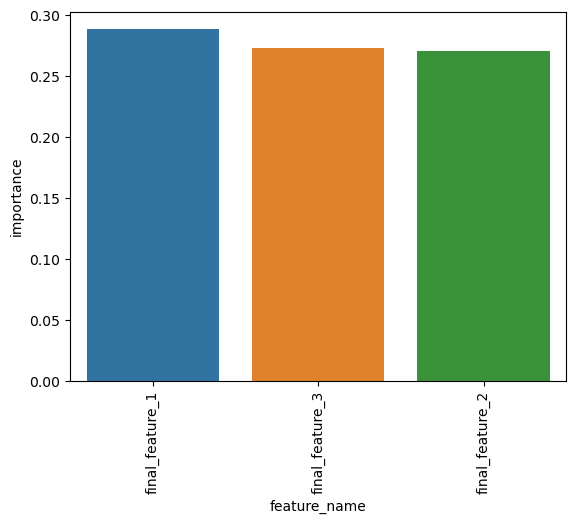

In [39]:
"""
INSTRUCTIONS
Plot the feature importance.
"""
column_names = []
num_numeric = best_parameters['extractor__pca__n_components'] + len(categorical_features_no)
for i in range(1,num_numeric+1):
    column_names.append('final_feature_'+str(i))

importance = pd.DataFrame(zip(best_model['rfc'].feature_importances_, column_names))
importance.columns = ['importance','feature_name']
importance_plot = sns.barplot(x=importance['feature_name'], y=importance['importance'], data=importance,orient='v',dodge=False,order=importance.sort_values('importance',ascending=False).feature_name)
for item in importance_plot.get_xticklabels(): #rotate the x labels by 90 degrees to avoid text overlapping
    item.set_rotation(90)
#plt.show()
plt.savefig(r'Results\%s.png' %("Importances"))


"""
TO SEE WHAT TARGET ENCODING IS DOING:
Read: https://archive.is/YGeoQ 
Read: https://archive.is/hACoX
"""
# use target encoding to encode two categorical features
enc = TargetEncoder(cols=['hour', 'day'])

# transform the datasets
x_train_out = enc.fit_transform(x_train, y_train)